In [1]:
import pandas as pd


df = pd.read_csv('/home/hyuksu/projects/ml/project/데이터/FIN_DATA_v4.csv',encoding='utf-8')
df

,DATE_YM,STATES,SIZE,PRICE_MEDIAN,COUNTS,PRICE_MEDIAN_LAG_1,PRICE_MEDIAN_LAG_2,PRICE_MEDIAN_LAG_3,CPI,BASE_RATE,...,BASE_RATE_LAG_2,CPI_YOY_LAG_2,REAL_RATE_LAG_2,HOUSE_RATE_LAG_2,CPI_LAG_3,BASE_RATE_LAG_3,CPI_YOY_LAG_3,REAL_RATE_LAG_3,HOUSE_RATE_LAG_3,VARIABLED
0,201504,강남구,대형,128750.0,246,130000.0,125000.0,132750.0,94.625,1.730,...,1.990,0.645882,1.344118,3.0,94.643,1.990,0.974074,1.015926,3.0,-0.030132
1,201505,강남구,대형,133000.0,204,128750.0,130000.0,125000.0,94.890,1.740,...,1.820,0.470511,1.349489,2.0,94.587,1.990,0.645882,1.344118,3.0,0.064000
2,201506,강남구,대형,131000.0,183,133000.0,128750.0,130000.0,94.909,1.570,...,1.730,0.436241,1.293759,2.0,94.596,1.820,0.470511,1.349489,2.0,0.007692
3,201507,강남구,대형,139250.0,176,131000.0,133000.0,128750.0,95.080,1.480,...,1.740,0.552088,1.187912,3.0,94.625,1.730,0.436241,1.293759,2.0,0.081553
4,201508,강남구,대형,135000.0,157,139250.0,131000.0,133000.0,95.213,1.490,...,1.570,0.701341,0.868659,3.0,94.890,1.740,0.552088,1.187912,3.0,0.015038
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4567,202506,중구,중형,120000.0,86,134500.0,120000.0,125000.0,116.310,2.520,...,2.769,2.078765,0.690235,3.0,116.290,2.754,2.053532,0.700468,4.0,-0.040000
4568,202507,중구,중형,115000.0,20,120000.0,134500.0,120000.0,116.520,2.500,...,2.738,1.901840,0.836160,3.0,116.380,2.769,2.078765,0.690235,3.0,-0.041667
4569,202508,중구,중형,129000.0,25,115000.0,120000.0,134500.0,116.450,2.506,...,2.520,2.169712,0.350288,3.0,116.270,2.738,1.901840,0.836160,3.0,-0.040892
4570,202509,중구,중형,137500.0,69,129000.0,115000.0,120000.0,117.060,2.526,...,2.500,2.094103,0.405897,3.0,116.310,2.520,2.169712,0.350288,3.0,0.145833


In [2]:
# ===============================
# 0. import
# ===============================
import numpy as np
import pandas as pd

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.mixture import GaussianMixture

# ===============================
# 1. 데이터 준비
# ===============================
df = df.copy().sort_values("DATE_YM").reset_index(drop=True)

# DATE_YM만 제거 (VARIABLED 포함 상태로 레짐을 보고 싶을 때)
X = df.drop(columns=["DATE_YM"])

# ===============================
# 2. 컬럼 타입 분리
# ===============================
cat_cols = X.select_dtypes(include="object").columns.tolist()
num_cols = X.select_dtypes(exclude="object").columns.tolist()

# ===============================
# 3. 전처리
# ===============================
preprocess = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
        ("log_cnt", FunctionTransformer(np.log1p), ["COUNTS"]),
        ("num", "passthrough", [c for c in num_cols if c != "COUNTS"]),
    ]
)

# ===============================
# 4. GMM 파이프라인
# ===============================
gmm_pipeline = Pipeline([
    ("prep", preprocess),
    ("scaler", StandardScaler(with_mean=False)),
    ("gmm", GaussianMixture(
        n_components=3,
        covariance_type="full",
        random_state=42
    ))
])

# ===============================
# 5. 시간순 분리
# ===============================
split_idx = int(len(X) * 0.73)
X_train = X.iloc[:split_idx]
X_test  = X.iloc[split_idx:]

# ===============================
# 6. 학습
# ===============================
gmm_pipeline.fit(X_train)

# ===============================
# 7. 결과
# ===============================
train_cluster = gmm_pipeline.predict(X_train)

train_result = df.iloc[:split_idx].copy()
train_result["cluster"] = train_cluster

print(train_result.groupby("cluster")["VARIABLED"].describe())


          count      mean       std       min       25%       50%       75%  \
cluster                                                                       
0         756.0  0.072480  0.265371 -0.772628 -0.034601  0.059073  0.153846   
1         457.0  0.013395  0.449945 -0.830233 -0.182648 -0.054945  0.125000   
2        2124.0  0.042624  0.201591 -0.731544 -0.031193  0.027586  0.086445   

              max  
cluster            
0        3.594575  
1        4.178082  
2        2.479167  


In [4]:
# =========================================================
# [BLOCK 1] GMM(EM) 학습 + 전체 데이터에 GMM feature 생성
# - 목적: gmm_label, gmm_p0..p(K-1) 컬럼을 df_feat에 추가
# - 누수 방지: GMM 학습 입력에서 VARIABLED 제외 (y를 보면 안 됨)
# - DATE_YM은 feature에서 제외 (시간 숫자 오해 방지)
# =========================================================

import numpy as np
import pandas as pd

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.mixture import GaussianMixture

df_feat = df.copy().sort_values("DATE_YM").reset_index(drop=True)
target = "VARIABLED"

# ---- GMM 입력(X_gmm): DATE_YM, target 제외
X_gmm = df_feat.drop(columns=["DATE_YM", target])

# (선택) PRICE_MEDIAN 포함/제외
# - 레짐 판단에 가격 레벨도 쓰고 싶으면 포함(기본)
# - 찝찝하면 아래 2줄 주석 해제해서 제외
# if "PRICE_MEDIAN" in X_gmm.columns:
#     X_gmm = X_gmm.drop(columns=["PRICE_MEDIAN"])

# ---- 타입 분리
cat_cols = X_gmm.select_dtypes(include="object").columns.tolist()
num_cols = X_gmm.select_dtypes(exclude="object").columns.tolist()

# ---- 전처리 + 스케일
preprocess_gmm = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
        ("log_cnt", FunctionTransformer(np.log1p, feature_names_out="one-to-one"), ["COUNTS"]),
        ("num", "passthrough", [c for c in num_cols if c != "COUNTS"]),
    ]
)

prep_scale = Pipeline([
    ("prep", preprocess_gmm),
    ("scaler", StandardScaler(with_mean=False))
])

# ---- 시간순 train/test 분리 (GMM도 train으로만 fit)
split_idx = int(len(X_gmm) * 0.73)
X_gmm_train = X_gmm.iloc[:split_idx]
X_gmm_test  = X_gmm.iloc[split_idx:]

Z_train = prep_scale.fit_transform(X_gmm_train)
Z_test  = prep_scale.transform(X_gmm_test)

# ---- GMM(EM) 학습
best_k = 3  # 일단 3 (나중에 BIC로 고를 수 있음)
gmm_final = GaussianMixture(
    n_components=best_k,
    covariance_type="full",
    random_state=42
)
gmm_final.fit(Z_train)

# ---- 전체 데이터에 대해 gmm 확률/라벨 생성 (transform만)
Z_all = prep_scale.transform(X_gmm)
prob_all = gmm_final.predict_proba(Z_all)
label_all = np.argmax(prob_all, axis=1)

df_feat["gmm_label"] = label_all
for i in range(best_k):
    df_feat[f"gmm_p{i}"] = prob_all[:, i]

print("[OK] df_feat에 gmm_label, gmm_p* 추가 완료")
print(df_feat[[ "DATE_YM", "STATES", "SIZE", "gmm_label"] + [f"gmm_p{i}" for i in range(best_k)]].head())


[OK] df_feat에 gmm_label, gmm_p* 추가 완료
   DATE_YM STATES SIZE  gmm_label  gmm_p0  gmm_p1  gmm_p2
0   201504     중구   중형          0     1.0     0.0     0.0
1   201504    강남구   소형          0     1.0     0.0     0.0
2   201504    양천구   소형          0     1.0     0.0     0.0
3   201504    광진구   소형          0     1.0     0.0     0.0
4   201504    강서구   대형          0     1.0     0.0     0.0


[BIC best K] 10
[AIC best K] 10


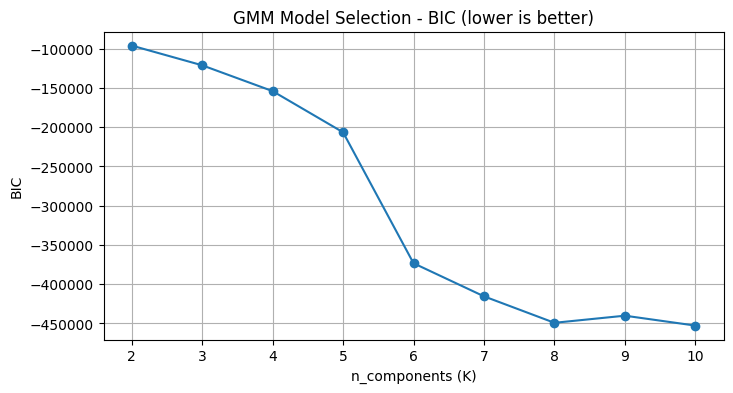

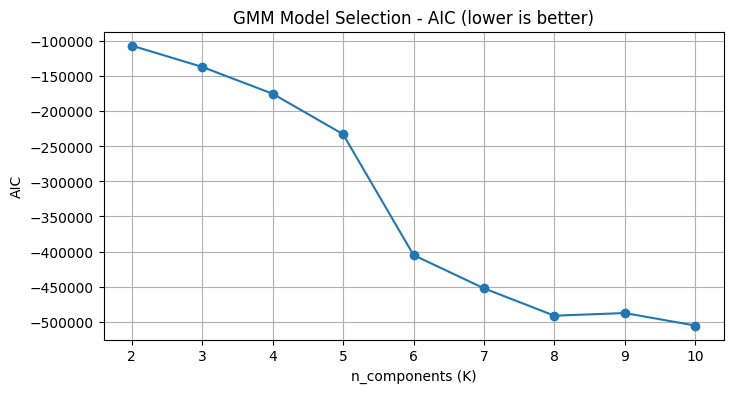

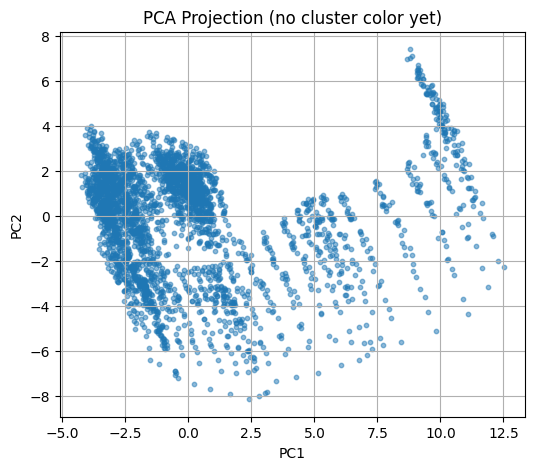

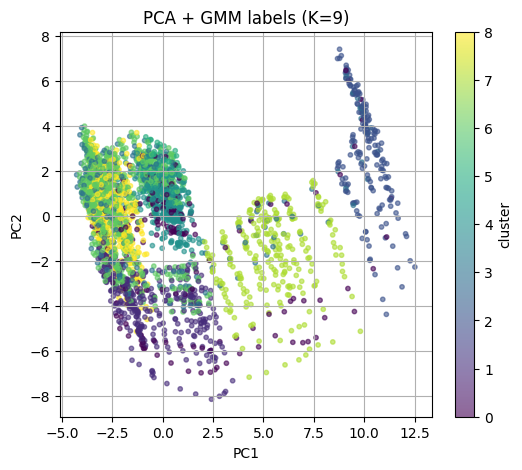

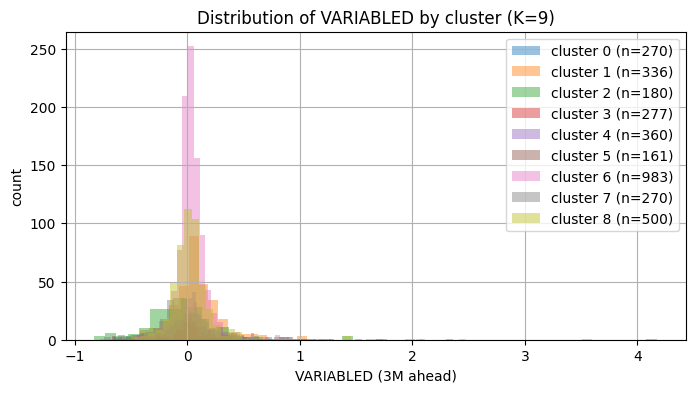

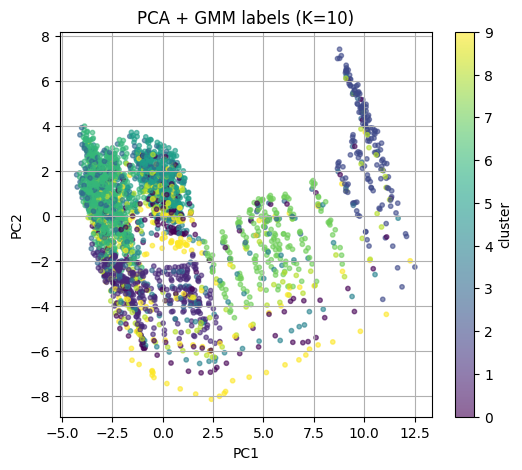

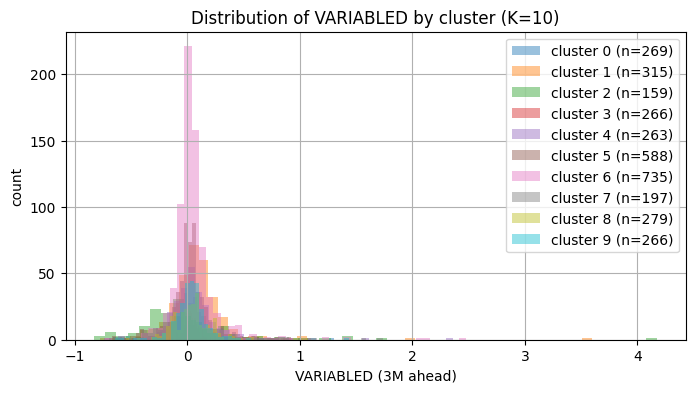

[OK] K 그래프 + K별 분포 시각화 완료


In [5]:
# =========================================================
# [BLOCK 1.5] K 선택 그래프(BIC/AIC) + K별 분포/클러스터 시각화
# - BLOCK 1에서 Z_train, prep_scale, X_gmm_train, df_feat, split_idx, target 만든 뒤 실행
# =========================================================

import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA

# -------------------------
# 1) K 후보별 BIC/AIC 계산
# -------------------------
Ks = list(range(2, 11))  # 필요하면 범위 조절 (2~15 이런 식)
bics, aics = [], []

for k in Ks:
    gmm = GaussianMixture(
        n_components=k,
        covariance_type="full",
        random_state=42
    )
    gmm.fit(Z_train)
    bics.append(gmm.bic(Z_train))
    aics.append(gmm.aic(Z_train))

best_k_bic = Ks[int(np.argmin(bics))]
best_k_aic = Ks[int(np.argmin(aics))]

print(f"[BIC best K] {best_k_bic}")
print(f"[AIC best K] {best_k_aic}")

# -------------------------
# 2) BIC/AIC 그래프
# -------------------------
plt.figure(figsize=(8, 4))
plt.plot(Ks, bics, marker="o")
plt.title("GMM Model Selection - BIC (lower is better)")
plt.xlabel("n_components (K)")
plt.ylabel("BIC")
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 4))
plt.plot(Ks, aics, marker="o")
plt.title("GMM Model Selection - AIC (lower is better)")
plt.xlabel("n_components (K)")
plt.ylabel("AIC")
plt.grid(True)
plt.show()

# 보통은 BIC 기반으로 K 선택 (더 보수적)
best_k = best_k_bic


# -------------------------
# 3) PCA 2D 투영 (클러스터 시각화용)
#    - 고차원 Z_train을 2D로 줄여서 cluster 분리 느낌 확인
# -------------------------
pca = PCA(n_components=2, random_state=42)
Z2 = pca.fit_transform(Z_train)

plt.figure(figsize=(6, 5))
plt.scatter(Z2[:, 0], Z2[:, 1], s=10, alpha=0.5)
plt.title("PCA Projection (no cluster color yet)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(True)
plt.show()


# -------------------------
# 4) K별로 '분포'를 보고 싶다 했으니
#    - K를 몇 개 골라서(예: best_k 주변) 분포를 비교
#    - (a) PCA에서 cluster color
#    - (b) cluster별 VARIABLED 분포(히스토그램)
# -------------------------
y_train = df_feat.iloc[:split_idx][target].values

# 볼 K 후보들 (best_k 주변으로 3개)
k_candidates = sorted(set([k for k in [best_k - 1, best_k, best_k + 1] if k in Ks]))

for k in k_candidates:
    gmm_k = GaussianMixture(
        n_components=k,
        covariance_type="full",
        random_state=42
    )
    gmm_k.fit(Z_train)
    label_k = gmm_k.predict(Z_train)

    # ---- (a) PCA 2D 클러스터 컬러 시각화
    plt.figure(figsize=(6, 5))
    plt.scatter(Z2[:, 0], Z2[:, 1], c=label_k, s=10, alpha=0.6)
    plt.title(f"PCA + GMM labels (K={k})")
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.grid(True)
    plt.colorbar(label="cluster")
    plt.show()

    # ---- (b) 클러스터별 VARIABLED 분포 (겹쳐서 히스토그램)
    plt.figure(figsize=(8, 4))
    for c in range(k):
        vals = y_train[label_k == c]
        if len(vals) == 0:
            continue
        plt.hist(vals, bins=50, alpha=0.45, label=f"cluster {c} (n={len(vals)})")

    plt.title(f"Distribution of VARIABLED by cluster (K={k})")
    plt.xlabel("VARIABLED (3M ahead)")
    plt.ylabel("count")
    plt.grid(True)
    plt.legend()
    plt.show()

print("[OK] K 그래프 + K별 분포 시각화 완료")


In [7]:
# =========================================================
# [BLOCK 2] SVR 학습/예측 (GMM feature 포함)
# - y = VARIABLED (3개월 뒤 변화율)
# - X = DATE_YM 제외 + (학습 정책에 따라 PRICE_MEDIAN 제외/포함)
# - COUNTS는 파이프라인에서 log1p 처리
# =========================================================

import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

target = "VARIABLED"

# ---- SVR 입력 만들기
X_svr = df_feat.drop(columns=["DATE_YM", target])
y = df_feat[target].values

# (권장 기본) PRICE_MEDIAN 제거: 현재값이라 예측에 섞이면 해석이 애매할 수 있음
# 학습 때 포함하고 싶으면 아래 2줄 주석 처리
#if "PRICE_MEDIAN" in X_svr.columns:
    #X_svr = X_svr.drop(columns=["PRICE_MEDIAN"])

# ---- 시간순 train/test 분리
split_idx = int(len(X_svr) * 0.73)
X_train = X_svr.iloc[:split_idx]
X_test  = X_svr.iloc[split_idx:]
y_train = y[:split_idx]
y_test  = y[split_idx:]

# ---- 전처리 (OHE + COUNTS log + 나머지 통과)
cat_cols = X_train.select_dtypes(include="object").columns.tolist()
num_cols = X_train.select_dtypes(exclude="object").columns.tolist()

preprocess_svr = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
        ("log_cnt", FunctionTransformer(np.log1p, feature_names_out="one-to-one"), ["COUNTS"]),
        ("num", "passthrough", [c for c in num_cols if c != "COUNTS"]),
    ]
)

svr_model = Pipeline([
    ("prep", preprocess_svr),
    ("scaler", StandardScaler(with_mean=False)),
    ("svr", SVR(kernel="rbf", C=10.0, epsilon=0.1, gamma="scale"))
])
svr_model.fit(X_train, y_train)
# train값 평가
train_pred = svr_model.predict(X_train)
train_mae = mean_absolute_error(y_train, train_pred)
train_rmse = np.sqrt(mean_squared_error(y_train, train_pred))
r2=r2_score(y_train, train_pred)
print(f"[SVR + GMM features] train_MAE={train_mae:.6f} train_RMSE={train_rmse:.6f} train_R2={r2:.6f}")




# ---- 학습 + 예측

pred = svr_model.predict(X_test)

# ---- 평가
mae = mean_absolute_error(y_test, pred)
rmse = np.sqrt(mean_squared_error(y_test, pred))
r2 = r2_score(y_test, pred)

print(f"[SVR + GMM features] MAE={mae:.6f} RMSE={rmse:.6f} R2={r2:.6f}")


[SVR + GMM features] train_MAE=0.075556 train_RMSE=0.165444 train_R2=0.585400
[SVR + GMM features] MAE=0.214809 RMSE=0.337688 R2=0.210315


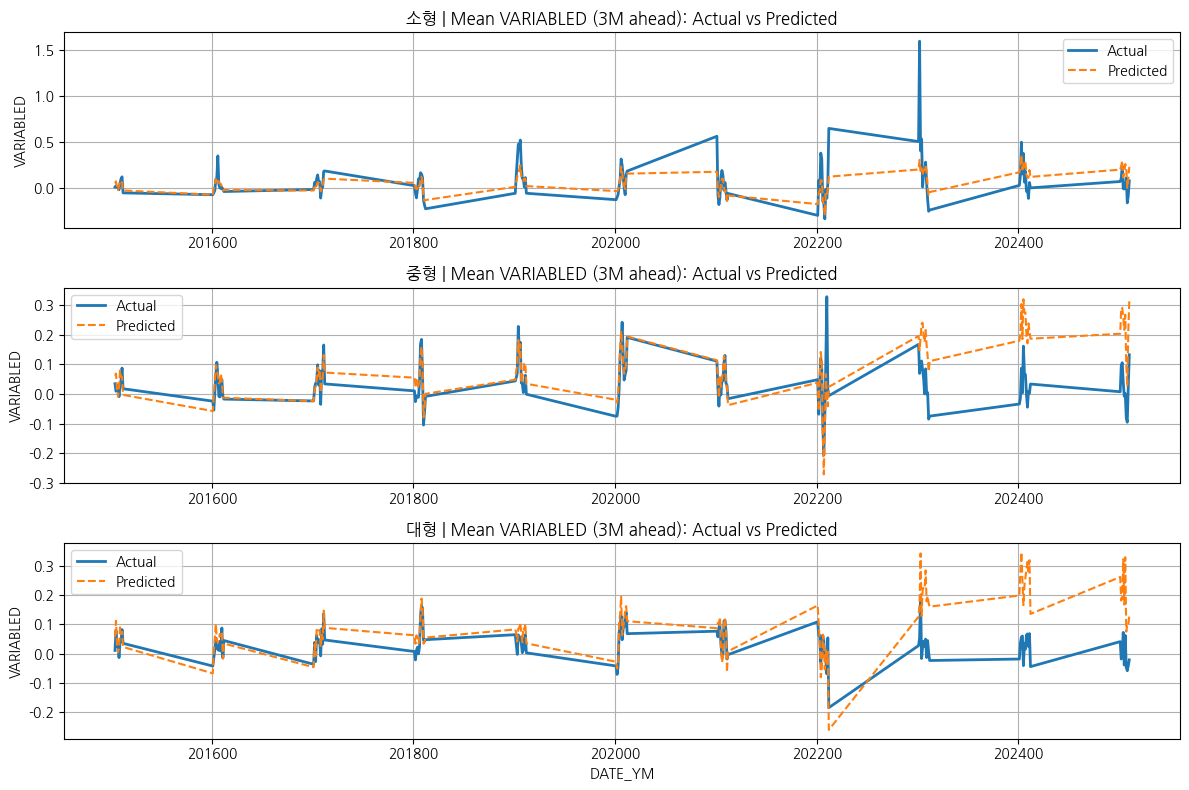

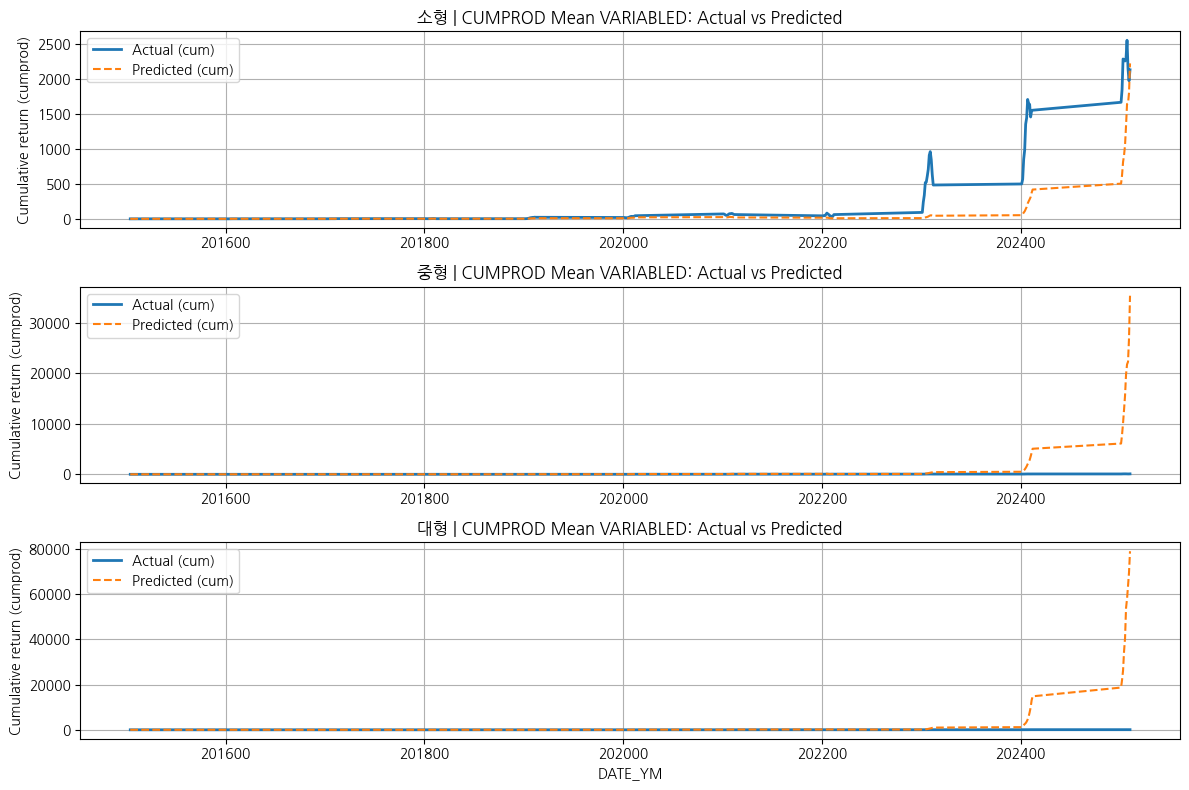

In [8]:
# ============================================
# 전체데이터 예측/시각화 (SVR이 GMM feature 포함 모델일 때) - 안전 수정본
# - 핵심: df_feat(=GMM feature 포함된 데이터)를 그대로 사용해서 예측
# - COUNTS log1p는 svr_model 파이프라인 내부에서 자동 처리됨
# - 누적은 (선택) cumsum(추세용) / cumprod(진짜 누적) 둘 다 제공
# ============================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rc

plt.rcParams['font.family'] = 'D2Coding'
plt.rcParams['axes.unicode_minus'] = False
rc('font', family='NanumGothic')

target = "VARIABLED"

# ----------------------------
# 0) df_feat 기준으로 전체 데이터 준비
#    (df_feat에는 이미 gmm_label, gmm_p*가 들어있다고 가정)
# ----------------------------
df_all = df_feat.copy().sort_values("DATE_YM").reset_index(drop=True)

# ----------------------------
# 1) SVR 입력 만들기 (학습 때와 동일하게)
# ----------------------------
X_all = df_all.drop(columns=["DATE_YM", target])

# (학습 때 PRICE_MEDIAN 제거했으면 동일하게 제거)
#if "PRICE_MEDIAN" in X_all.columns:
   # X_all = X_all.drop(columns=["PRICE_MEDIAN"])

y_true_all = df_all[target].values

# ✅ 여기서 COUNTS를 log로 바꾸지 않음
#    이유: svr_model 내부 preprocess에서 ("log_cnt", log1p, ["COUNTS"]) 처리됨
y_pred_all = svr_model.predict(X_all)

df_all["y_true"] = y_true_all
df_all["y_pred"] = y_pred_all

# ----------------------------
# 2) 서울 전체 SIZE별, DATE_YM별 평균 변화율 계산
# ----------------------------
grouped_all = (
    df_all.groupby(["DATE_YM", "SIZE"])
          .agg(y_true_mean=("y_true", "mean"),
               y_pred_mean=("y_pred", "mean"))
          .reset_index()
)

# ----------------------------
# 3) 시각화: 변화율 추이
# ----------------------------
sizes = ["소형", "중형", "대형"]

plt.figure(figsize=(12, 8))
for i, size in enumerate(sizes):
    sub = grouped_all[grouped_all["SIZE"] == size]
    plt.subplot(3, 1, i+1)
    plt.plot(sub["DATE_YM"], sub["y_true_mean"], label="Actual", linewidth=2)
    plt.plot(sub["DATE_YM"], sub["y_pred_mean"], label="Predicted", linestyle="--")
    plt.title(f"{size} | Mean VARIABLED (3M ahead): Actual vs Predicted")
    plt.ylabel("VARIABLED")
    plt.grid(True)
    plt.legend()

plt.xlabel("DATE_YM")
plt.tight_layout()
plt.show()

# ----------------------------
# 4) 시각화: 누적 추이
#    (A) cumsum: 추세/방향성 보기 좋음
#    (B) cumprod: 진짜 누적(복리) 정의에 맞음
# ----------------------------
use_cumprod = True   # True면 진짜 누적(cumprod), False면 추세용(cumsum)

plt.figure(figsize=(12, 8))
for i, size in enumerate(sizes):
    sub = grouped_all[grouped_all["SIZE"] == size].copy()

    if use_cumprod:
        sub["cum_true"] = (1 + sub["y_true_mean"]).cumprod() - 1
        sub["cum_pred"] = (1 + sub["y_pred_mean"]).cumprod() - 1
        ylab = "Cumulative return (cumprod)"
        title_suffix = "CUMPROD"
    else:
        sub["cum_true"] = sub["y_true_mean"].cumsum()
        sub["cum_pred"] = sub["y_pred_mean"].cumsum()
        ylab = "Cumulative VARIABLED (cumsum)"
        title_suffix = "CUMSUM"

    plt.subplot(3, 1, i+1)
    plt.plot(sub["DATE_YM"], sub["cum_true"], label="Actual (cum)", linewidth=2)
    plt.plot(sub["DATE_YM"], sub["cum_pred"], label="Predicted (cum)", linestyle="--")
    plt.title(f"{size} | {title_suffix} Mean VARIABLED: Actual vs Predicted")
    plt.ylabel(ylab)
    plt.grid(True)
    plt.legend()

plt.xlabel("DATE_YM")
plt.tight_layout()
plt.show()
